# Fundamentals of Portfolio Analysis

Support Functions for Statistical Analysis of financial asset allocation

In [48]:
import fin_analysis_functions as fin_fun
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
df = fin_fun.get_ind_returns()
df.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


In [56]:
sectors = ['Food', 'Beer', 'Smoke', 'Coal']

er = fin_fun.annualize_rets(df['1996':'2000'], 12)
cov_matrix = df['1996':'2000'].cov()

In [68]:
weights = np.array([1/4]*4)
weights.T

array([0.25, 0.25, 0.25, 0.25])

In [92]:
weights = np.array([np.array([w, 1-w]) for w in np.linspace(0, 1, 20)])
industries = ['Food', 'Beer']
r = er[industries]

rets = [fin_fun.porftolio_returns(w, r) for w in weights]
vols = [fin_fun.porftolio_vol(w, cov_matrix.loc[industries, industries]) for w in weights]

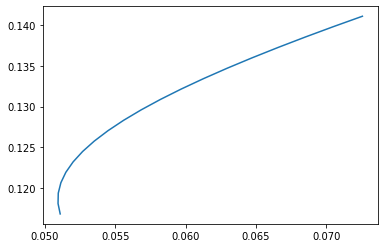

In [94]:
plt.plot(vols, rets)